In [30]:
%load_ext autoreload
%autoreload 2
import torch
import torch.optim as optim
import tqdm.notebook as tqdm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import ToPILImage
from IPython.display import Image

import copy
import os
import sys
sys.path.append('/Users/Matt/projects/gmmvae/')

import gmmvae

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data preparation.

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST('../data', train=True, download=True,
                               transform=transform)
test_dataset = datasets.MNIST('../data', train=False,
                              transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

## Classifier training.

In [3]:
def train_cls(model, train_loader, optimiser, epoch):
    model.train()
    batch_iter = tqdm.tqdm(enumerate(train_loader), desc='Batch')
    for batch_idx, (x, y) in batch_iter:
        optimiser.zero_grad()
        loss, _ = model.nll(x, y)
        loss.backward()
        optimiser.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test_cls(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            loss, output = model.nll(x, y)
            test_loss += loss.item()
            
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [4]:
cls = gmmvae.classifiers.MNISTClassificationNet()
cls_optimiser = optim.Adadelta(cls.parameters(), lr=1.0)
cls_scheduler = StepLR(cls_optimiser, step_size=1, gamma=0.7)

In [5]:
for epoch in range(1, 14+1):
    train_cls(cls, train_loader, cls_optimiser, epoch)
    test_cls(cls, test_loader)
    cls_scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300908
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.783225
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.982101
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.908635
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.570533
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.405241
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.392480
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.334602
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.449880
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.300798
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.239030
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.428364
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.231438
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.503649
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.283750
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.310480
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.253507
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.141863
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.123825
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.272869
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.123555
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.300340
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.086207
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.210392
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.216992
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.029092
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.081565
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.012055
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.035101
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.180944
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.039921
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.008752
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.034947
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.062844
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.020710
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.020224
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.089810
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.189094
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.026648
Train Epoch: 2 [12160/60000 (20%)]	Loss: 0.033428
Train Epoch: 2 [12800/60000 (

KeyboardInterrupt: 

## Set GMMVAE datasets. 

In [6]:
pred_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False)
cls_output = torch.zeros(len(train_dataset), 10)
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(pred_loader):
        cls_output[batch_idx*64:(batch_idx+1)*64] = cls(x).detach().exp()

In [7]:
class GMMVAEDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, cls_output):
        self.x = x
        self.y = y
        self.cls_output = cls_output
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        return self.x[idx, ...], self.cls_output[idx]
    
gmmvae_dataset = GMMVAEDataset(train_dataset.data, train_dataset.targets, cls_output)
gmmvae_loader = torch.utils.data.DataLoader(gmmvae_dataset, batch_size=64)

In [23]:
def train_gmmvae(model, loader, optimiser, epoch):
    model.train()
    train_loss = 0
    batch_iter = tqdm.tqdm(enumerate(loader), desc='Batch')
    
    for batch_idx, (x, pi) in batch_iter:
        optimiser.zero_grad() 
        if isinstance(model, gmmvae.models.GMMVAEFixedCls):
            x = x.unsqueeze(1).float() / 255
            loss = -model.elbo(x, pi, num_samples=1)
        elif isinstance(model, gmmvae.models.VAE):
            x = x.view(-1, 784).float() / 255
            loss = -model.elbo(x, num_samples=1)
        else:
            x = x.view(-1, 784).float() / 255
            loss = -model.elbo(x, pi, num_samples=1)
        
        loss.backward()
        
        optimiser.step()
        
        train_loss += loss.item()        
        batch_iter.set_postfix(loss=loss.item())
            
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(loader.dataset)))

In [20]:
z_dim = 2
x_dim = 784

encoder = gmmvae.networks.LinearGaussian(x_dim, z_dim, [512, 256], min_sigma=1e-3)
cls_encoder = gmmvae.networks.LinearGaussianIndexed(x_dim, z_dim, 10, [512, 256], min_sigma=1e-3)
loglikelihood = gmmvae.loglikelihoods.NNBernoulli(z_dim, x_dim, [256, 512])

gmmvae_cls = copy.deepcopy(cls)
for param in gmmvae_cls.parameters():
    param.requires_grad = False

# gmmvae_model = gmmvae.models.GMMVAE(
#     copy.deepcopy(loglikelihood), gmmvae_encoder, z_dim, 10)
# gmmvaecls_model = gmmvae.models.GMMVAEFixedCls(
#     copy.deepcopy(loglikelihood), gmmvae_cls, gmmvaecls_encoder,  z_dim, 10)

# weighted_vae = gmmvae.models.WeightedVAE(
#     copy.deepcopy(loglikelihood), copy.deepcopy(encoder), z_dim, 10)
vae = gmmvae.models.VAE(copy.deepcopy(loglikelihood), copy.deepcopy(encoder), z_dim)

## GMMVAE training.

In [14]:
optimiser = optim.Adam(weighted_vae.parameters())
for epoch in range(1, 14+1):
    train_gmmvae(weighted_vae, gmmvae_loader, optimiser, epoch)


====> Epoch: 1 Average loss: 2.7606



====> Epoch: 2 Average loss: 2.4668



====> Epoch: 3 Average loss: 2.3848



====> Epoch: 4 Average loss: 2.3361



====> Epoch: 5 Average loss: 2.2980



====> Epoch: 6 Average loss: 2.2692



====> Epoch: 7 Average loss: 2.2496



====> Epoch: 8 Average loss: 2.2340



====> Epoch: 9 Average loss: 2.2212



====> Epoch: 10 Average loss: 2.2120



====> Epoch: 11 Average loss: 2.2003



====> Epoch: 12 Average loss: 2.1929



====> Epoch: 13 Average loss: 2.1849



====> Epoch: 14 Average loss: 2.1771


In [24]:
vae_optimiser = optim.Adam(vae.parameters())
for epoch in range(1, 14+1):
    train_gmmvae(vae, gmmvae_loader, vae_optimiser, epoch)


====> Epoch: 1 Average loss: 2.8515



====> Epoch: 2 Average loss: 2.5365



====> Epoch: 3 Average loss: 2.4370



====> Epoch: 4 Average loss: 2.3814



====> Epoch: 5 Average loss: 2.3452



====> Epoch: 6 Average loss: 2.3169



====> Epoch: 7 Average loss: 2.2941



====> Epoch: 8 Average loss: 2.2802



====> Epoch: 9 Average loss: 2.2663



====> Epoch: 10 Average loss: 2.2560



====> Epoch: 11 Average loss: 2.2490



====> Epoch: 12 Average loss: 2.2368



====> Epoch: 13 Average loss: 2.2289



====> Epoch: 14 Average loss: 2.2252


## Sample model.

In [20]:
if not os.path.exists('./samples'):
    os.makedirs('./samples')

with torch.no_grad():            
    sample = gmmvae_model.sample(num_samples=100)
    
    filename = './samples/gmmvae_sample'
    
    if os.path.exists(filename + '.png'):
        i = 1
        while os.path.exists(filename + '_' + str(i) + '.png'):
            i += 1
            
        filename = filename + '_' + str(i) + '.png'
        
    else:
        filename = filename + '.png'
    
    save_image(sample.view(100, 1, 28, 28), filename)

## Visualise clustering of latent space.

In [16]:
from matplotlib.patches import Ellipse, Rectangle

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes.
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmmvae(gmmvae, x, y, pi, ax=None):
    ax = ax or plt.gca()
    z = gmmvae.encoder(x)[0].detach()
    h = - (pi * (pi.log()) / np.log(2)).sum(1)
    
    colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
    c = [colours[y_] for y_ in y]
#     s = 50 * h / h.max()
    s = 20
    ax.scatter(z[:, 0], z[:, 1], c=c, alpha=.75, marker='x', s=s)
    ax.axis('equal')
    
    for mu, logsigma, colour in zip(gmmvae.pz_y_mu, gmmvae.pz_y_logsigma, colours):
        mu = mu.detach().numpy()
        cov = logsigma.exp().diag_embed().detach().numpy()
        draw_ellipse(mu, cov, alpha=.1, color=colour)
        

def plot_vae(model, x, y, pi, ax=None):
    ax = ax or plt.gca()
    z = model.encoder(x)[0].detach()
    h = - (pi * (pi.log()) / np.log(2)).sum(1)
    
    colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
    c = [colours[y_] for y_ in y]
    s = 20
    ax.scatter(z[:, 0], z[:, 1], c=c, alpha=.75, marker='x', s=s)
    ax.axis('equal')


def plot_gmmvaecls(model, x, y, pi, ax=None):
    ax = ax or plt.gca()
    z = model.encoder(x, y)[0].detach()
    h = - (pi * (pi.log()) / np.log(2)).sum(1)
    
    colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
    c = [colours[y_] for y_ in y]
#     s = 50 * h / h.max()
    s = 20
    ax.scatter(z[:, 0], z[:, 1], c=c, alpha=.75, marker='x', s=s)
    ax.axis('equal')
    
#     for mu, logsigma, colour in zip(model.pz_y_mu, model.pz_y_logsigma, colours):
#         mu = mu.detach().numpy()
#         cov = logsigma.exp().diag_embed().detach().numpy()
#         draw_ellipse(mu, cov, alpha=.1, color=colour)

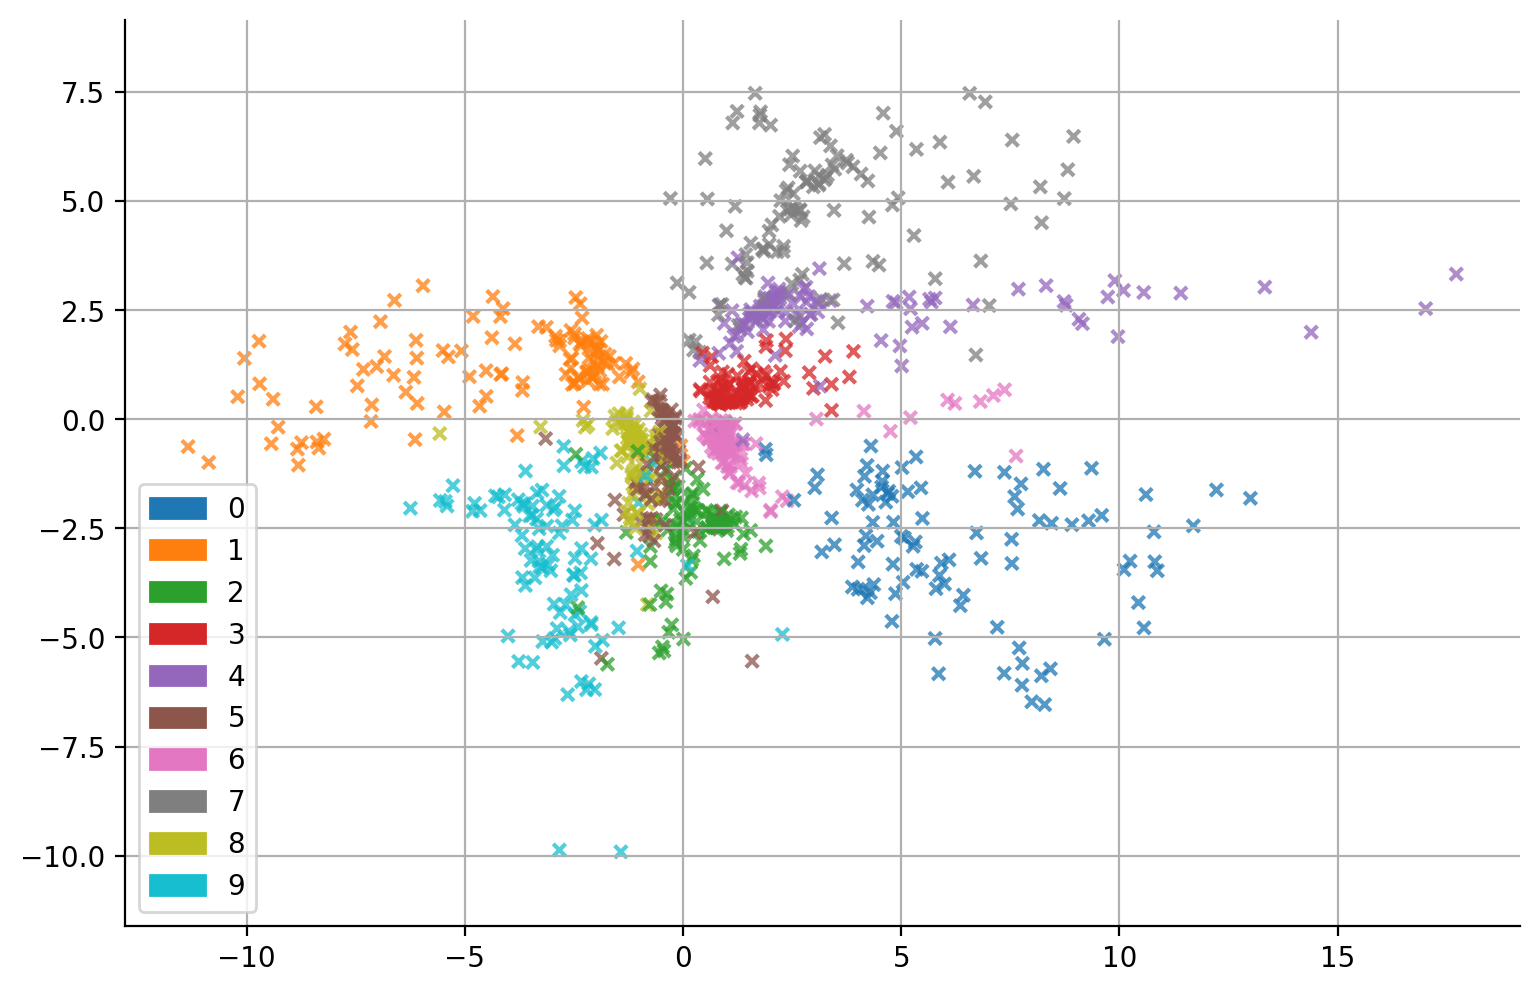

In [30]:
fig = plt.figure(figsize=(9, 6), dpi=200)

x = gmmvae_dataset.x[:1000].view(-1, 784).float() / 255
y = gmmvae_dataset.y[:1000]
pi = gmmvae_dataset.cls_output[:1000]
plot_gmmvaecls(gmmvaecls_model, x, y, pi)

# Hide the right and top spines.
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add legend.
colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
custom_patches = [Rectangle((0, 0), 1, 1, color=colours[i]) for i in range(10)]
ax.legend(custom_patches, [str(i) for i in range(10)])

plt.grid(0.25)
plt.show()

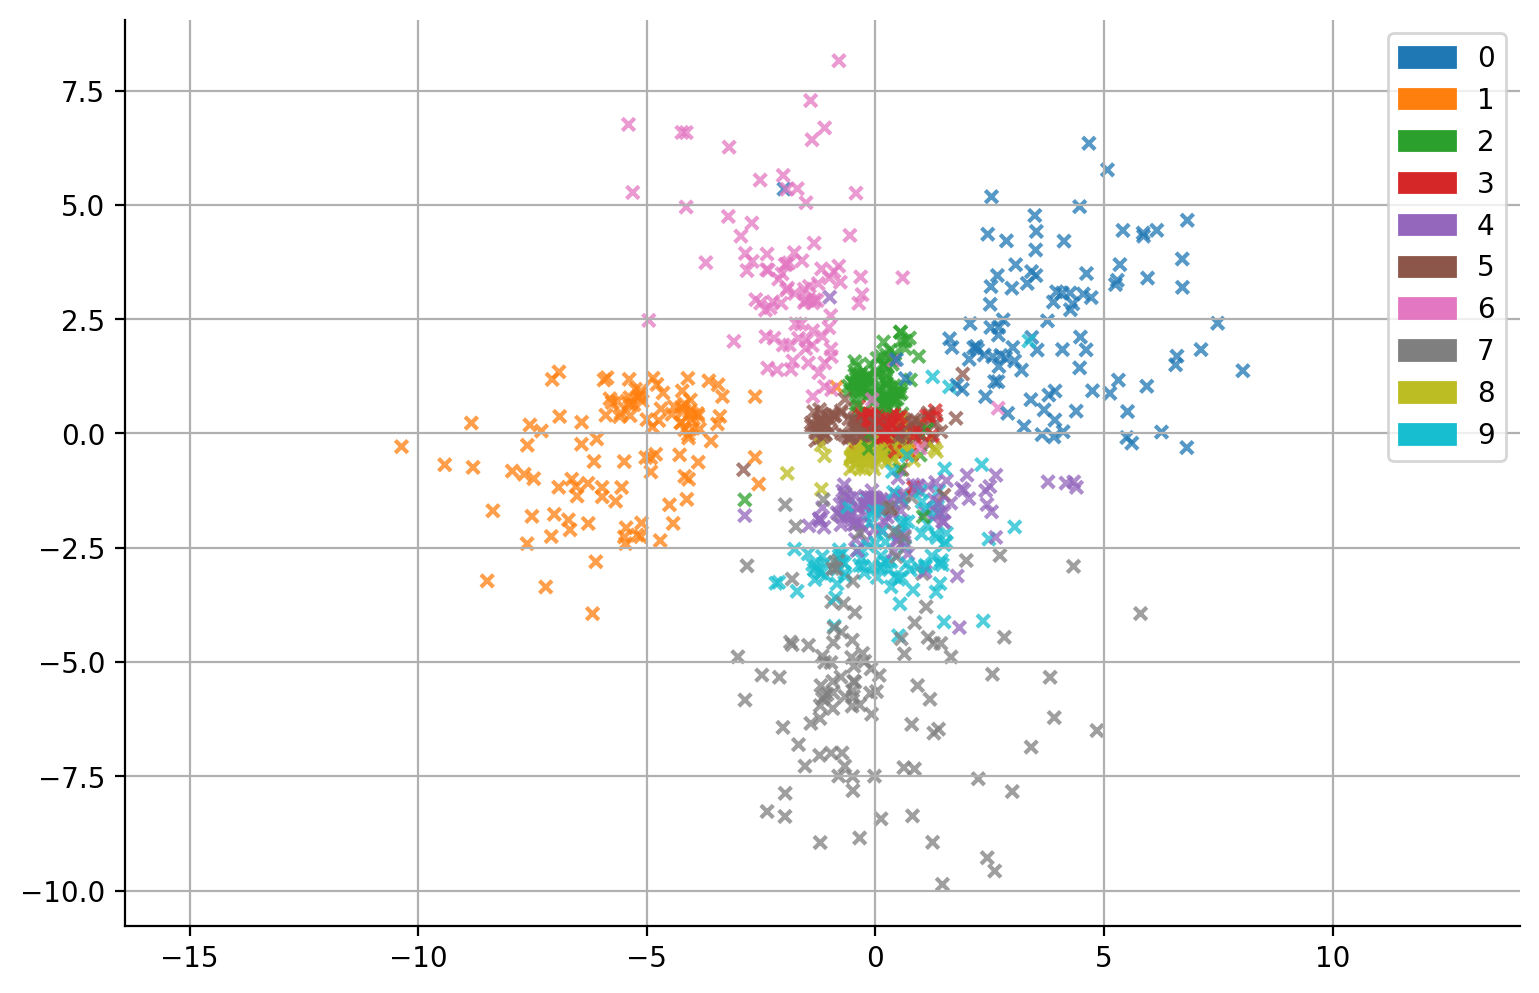

In [27]:
fig = plt.figure(figsize=(9, 6), dpi=200)

x = gmmvae_dataset.x[:1000].view(-1, 784).float() / 255
y = gmmvae_dataset.y[:1000]
pi = gmmvae_dataset.cls_output[:1000]
plot_vae(weighted_vae, x, y, pi)

# Hide the right and top spines.
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add legend.
colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
custom_patches = [Rectangle((0, 0), 1, 1, color=colours[i]) for i in range(10)]
ax.legend(custom_patches, [str(i) for i in range(10)])

plt.grid(0.25)
plt.savefig('../figures/mnist/weighted_vae_latent_space.png', dpi=400, bbox_inches='tight')
plt.show()

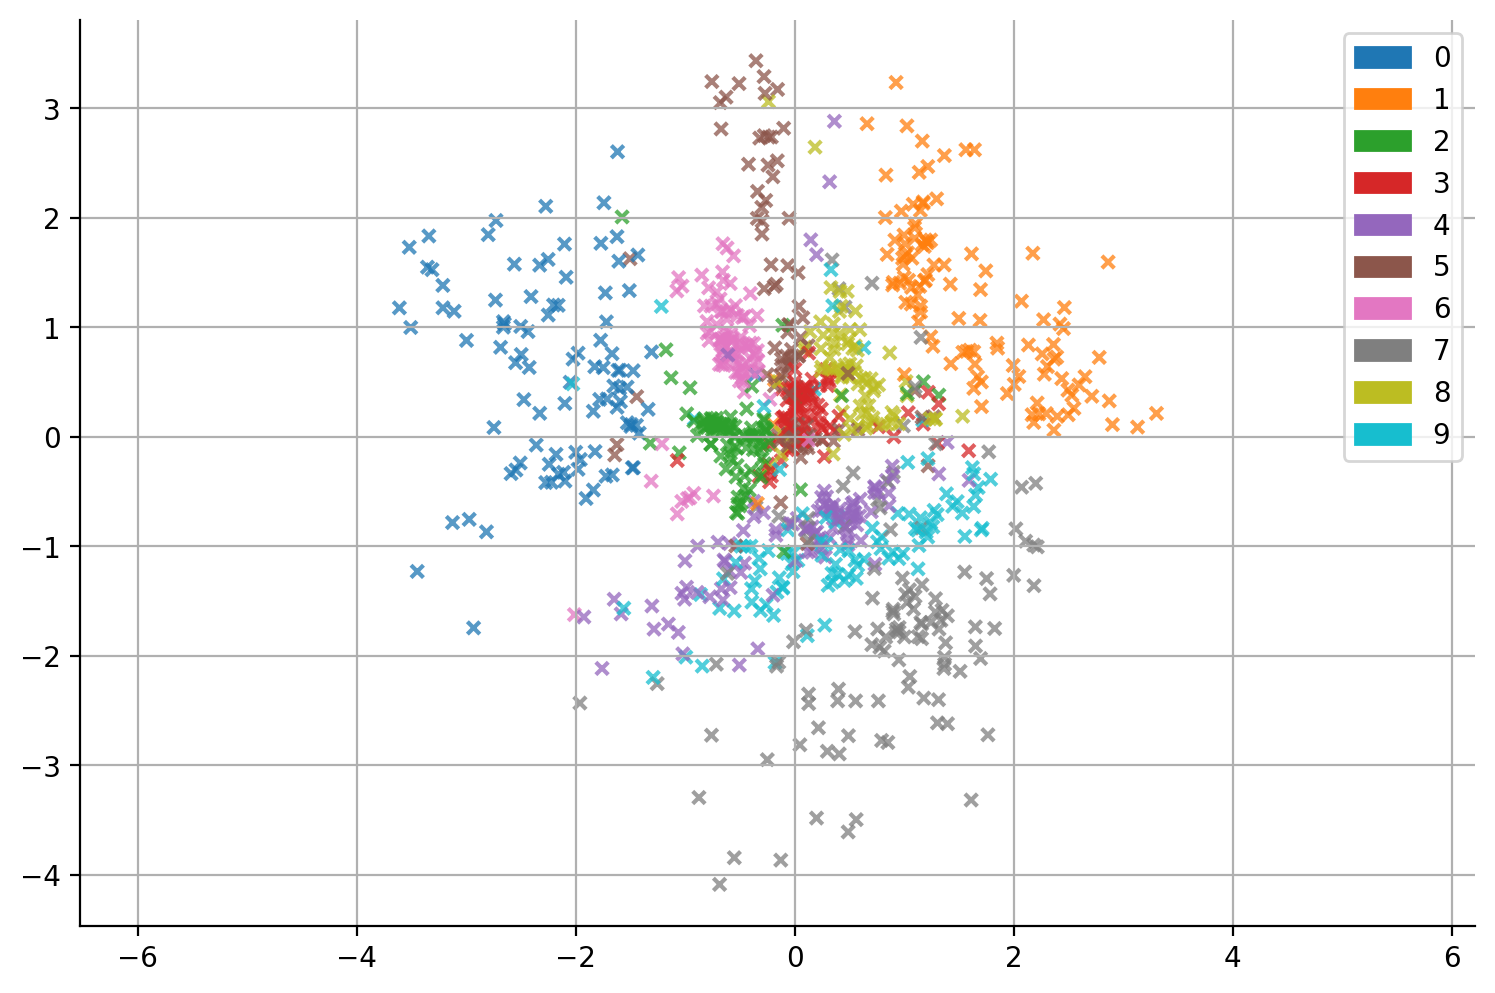

In [28]:
fig = plt.figure(figsize=(9, 6), dpi=200)

x = gmmvae_dataset.x[:1000].view(-1, 784).float() / 255
y = gmmvae_dataset.y[:1000]
pi = gmmvae_dataset.cls_output[:1000]
plot_vae(vae, x, y, pi)

# Hide the right and top spines.
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add legend.
colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
custom_patches = [Rectangle((0, 0), 1, 1, color=colours[i]) for i in range(10)]
ax.legend(custom_patches, [str(i) for i in range(10)])

plt.grid(0.25)
plt.savefig('../figures/mnist/vae_latent_space.png', dpi=400, bbox_inches='tight')
plt.show()

## Inspect individual samples

In [32]:
pi = torch.zeros(10)
pi[0:2] = 0.5

sample = weighted_vae.sample()

In [33]:
pi

tensor([0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])